In [30]:
from tqdm.notebook import tqdm
tqdm.pandas()
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# ! mkdir -p ~/aiffel/transformer_chatbot/data/
# ! ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv': File exists


In [10]:
!ls /aiffel/aiffel/transformer_chatbot/data
!echo $HOME

'ChatbotData .csv'
/aiffel


# 1. 데이터 전처리

[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)


1. 챗봇 트레이닝용 문답 페어 11,823개
2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [34]:
path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv' 
origin = pd.read_csv(path) 

print(origin.shape)
origin.sample(15)

(11823, 3)


,Q,A,label
5243,회의 망했어,다음에 잘 하면 돼요.,0
7880,잘살아야 되는데,바뀌어도 힘든 건 비슷하죠.,1
3558,울적한 기분이 안 없어져.,거리를 걸어보세요.,0
1662,면도 귀찬하,지저분해요.,0
8603,헤어진건 아닌데,헤어진 거 같나요.,1
1696,몇시간 동안 안와,기다리는 동안 많은 생각이 들었겠네요.,0
3367,오랜만에 떨려서 좋았는데,떨리는 감정은 그 자체로 소중해요.,0
8037,정말 무슨생각인지 궁금하네,궁금증을 접어두셔요.,1
1362,드디어 손 잡음,좋았겠어요.,0
10529,여자가 남자한테 잘해주면 질려?,좋은 사람이라면 고마워할 거예요.,2


In [50]:
df = origin.copy()

In [51]:
def preprocess(sentence):
    # 혹시 모를 영어 처리
    sentence = sentence.lower().strip()
    # 구두점 앞뒤에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 개의 연속된 공백을 하나의 공백으로 치환
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글 자모, 구두점, 영어 알파벳을 제외한 모든 문자를 공백으로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

def postprocess(df):
    # null 제거
    df.replace('', np.nan, inplace=True)
    df.dropna(subset=['Q'], inplace=True)
    df.dropna(subset=['A'], inplace=True)



test_sentences = [
    "안녕하세요! Hello, how are you?",
    "오늘 날씨가 정말 좋네요. It's a beautiful day.",
    "가격은 1000원 입니다.🔥 🔥 ",
    "오늘은 2024년 6월 20일입니다. Happy coding!"
]

for sentence in test_sentences:
    print(f"Original: {sentence}")
    print(f"Processed: {preprocess(sentence)}")
    print()

Original: 안녕하세요! Hello, how are you?
Processed: 안녕하세요 ! hello , how are you ?

Original: 오늘 날씨가 정말 좋네요. It's a beautiful day.
Processed: 오늘 날씨가 정말 좋네요 . it s a beautiful day .

Original: 가격은 1000원 입니다.🔥 🔥 
Processed: 가격은 원 입니다 .

Original: 오늘은 2024년 6월 20일입니다. Happy coding!
Processed: 오늘은 년 월 일입니다 . happy coding !



In [52]:
# label drop
df = df.drop(columns=['label'])
# Q,A 중복인 경우만 제거
df.drop_duplicates(subset = ['Q', 'A'], inplace = True)
print(df.shape)

df['Q'] = df['Q'].progress_apply(preprocess)
df['A'] = df['A'].progress_apply(preprocess)
postprocess(df)
print(df.shape)

(11750, 2)


  0%|          | 0/11750 [00:00<?, ?it/s]

  0%|          | 0/11750 [00:00<?, ?it/s]

(11750, 2)


Q의 최소 길이 : 1
Q의 최대 길이 : 16
Q의 평균 길이 : 3.9419574468085106
A의 최소 길이 : 1
A의 최대 길이 : 24
A의 평균 길이 : 4.716595744680851


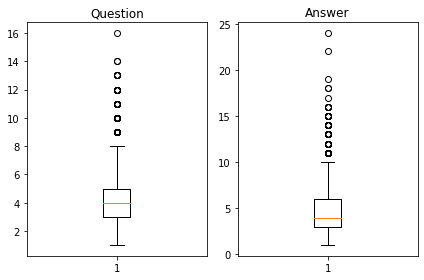

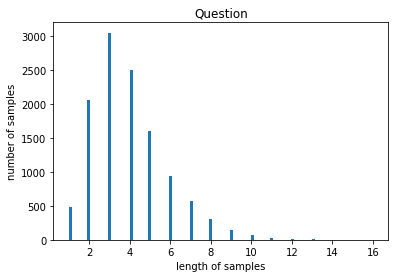

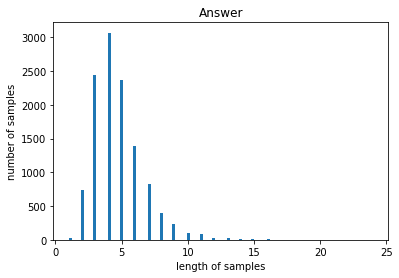

In [53]:
import matplotlib.pyplot as plt


question_len = [len(s.split()) for s in df['Q']]
answer_len = [len(s.split()) for s in df['A']]

print('Q의 최소 길이 : {}'.format(np.min(question_len)))
print('Q의 최대 길이 : {}'.format(np.max(question_len)))
print('Q의 평균 길이 : {}'.format(np.mean(question_len)))
print('A의 최소 길이 : {}'.format(np.min(answer_len)))
print('A의 최대 길이 : {}'.format(np.max(answer_len)))
print('A의 평균 길이 : {}'.format(np.mean(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('Question')
plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('Answer')
plt.tight_layout()
plt.show()

plt.title('Question')
plt.hist(question_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answer')
plt.hist(answer_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [54]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split()) <= max_len:
            cnt = cnt + 1
    print(
        "전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"
        % (max_len, (cnt / len(nested_list)))
    )

# 적절한 임의의 최대 길이
q_len = 10
a_len = 12
MAX_LENGTH = max(q_len, a_len) # 12

below_threshold_len(q_len, df["Q"])
below_threshold_len(a_len, df["A"])

전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9955744680851064
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9943829787234043


In [55]:
before = len(df)

def is_within(text, max_len):
    return len(text.split()) <= max_len


filtered_q = df["Q"].apply(is_within, max_len=q_len)
filtered_a = df["A"].apply(is_within, max_len=a_len)

# merge
df = df[filtered_q & filtered_a]
print("전체 샘플수 :", (len(df)))
print(f"삭제된 샘플수: {before - len(df)}")

전체 샘플수 : 11632
삭제된 샘플수: 118


# 2. 전처리 part2
> 병렬 데이터 전처리

In [56]:
questions, answers = df["Q"],df["A"]
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8181]
END_TOKEN의 번호 : [8182]
8183


In [57]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5728, 600, 2784, 4092]
정수 인코딩 후의 21번째 답변 샘플: [2619, 7517, 9, 6248, 97, 1]


In [58]:
def tokenize_and_filter(inputs, outputs, max_length):
    tokenized_inputs, tokenized_outputs = [], []

    for q, a in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        q = START_TOKEN + tokenizer.encode(q) + END_TOKEN
        a = START_TOKEN + tokenizer.encode(a) + END_TOKEN

        # max_length 이하인 경우에만 데이터셋으로 허용
        if len(q) <= max_length and len(a) <= max_length:
            tokenized_inputs.append(q)
            tokenized_outputs.append(a)

    # max_length 으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_length, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding="post"
    )

    return tokenized_inputs, tokenized_outputs

print(MAX_LENGTH)
questions, answers = tokenize_and_filter(questions, answers, MAX_LENGTH)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

12
단어장의 크기 : 8183
필터링 후의 질문 샘플 개수: 10673
필터링 후의 답변 샘플 개수: 10673


(11632, 2)

# 3. 데이터 전처리
> Teacher Forcing

In [59]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 4. 모델 학습


## 4-1. 공통 코드
> 인코더, 디코더 공용

1. PositionalEncoding
2. padding mask
3. scaled_dot_product_attention
4. MultiHeadAttention

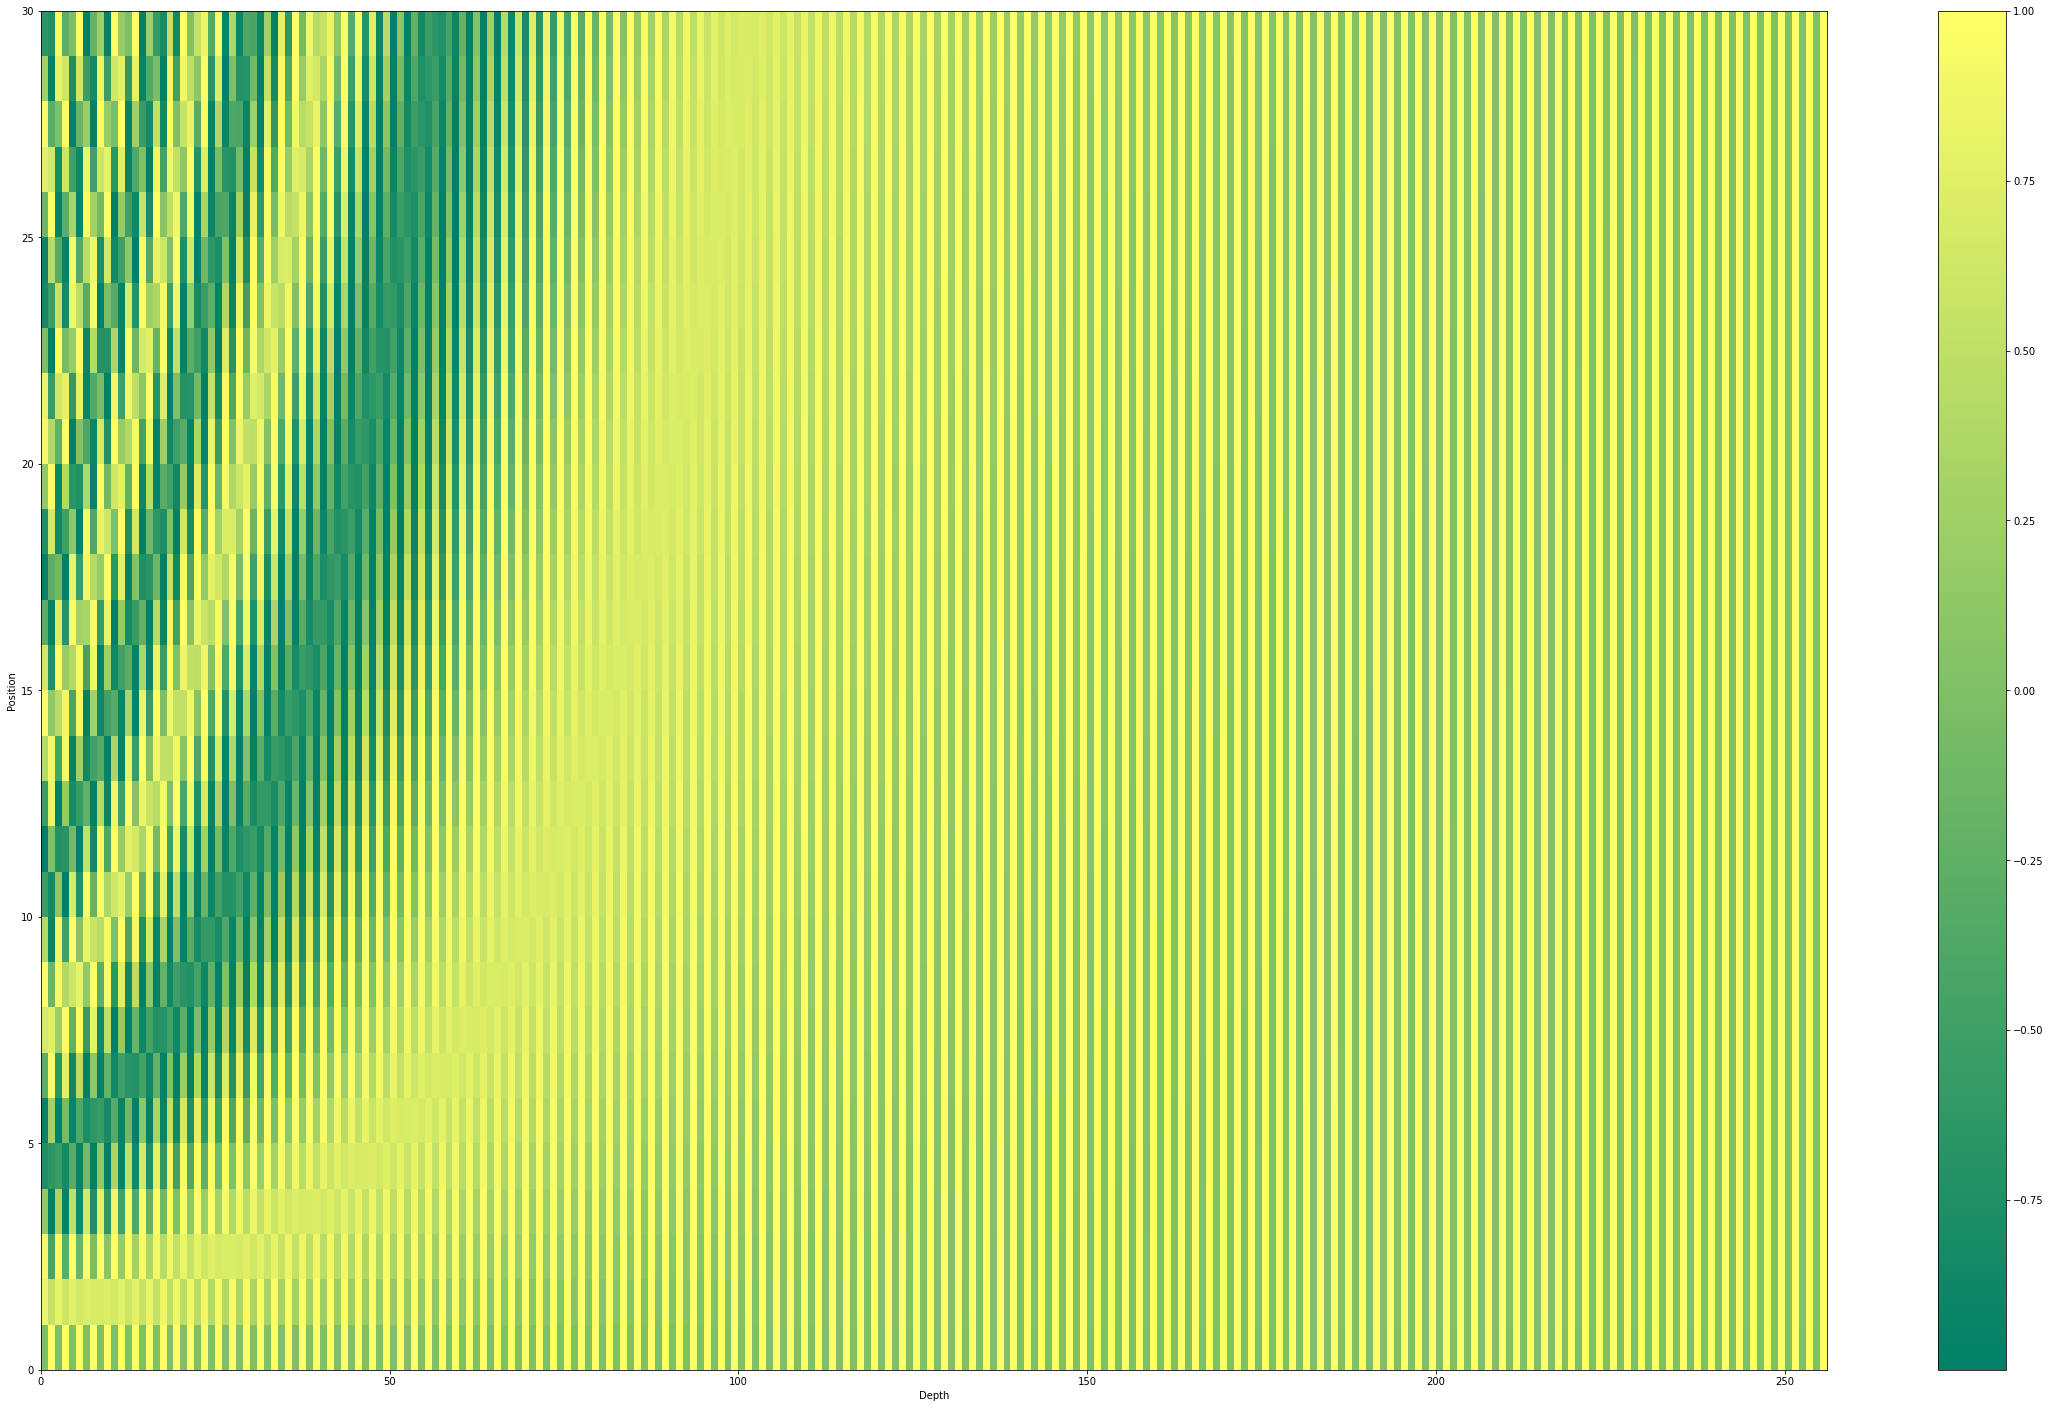

In [63]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position=50, d_model=128):
        super(PositionalEncoding, self).__init__()
        # (1, 50, 128)
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles  # broadcasting (50, 128)

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성 (50, 128)
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # (50, 1)
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],  # (1, 128)
            d_model=d_model,
        )

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])  # (50, 64)
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])  # (50, 64)

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)  # (2, 50, 64)
        # Transpose시 0축(2)가 2축으로 보낼 때, z축이 합쳐지면서 2개의 row로 pair가 만들어진다.
        # [[1,1], [2,2]] -> [[1,2], [1,2]]
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])  # (50, 64, 2)
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])  # (50, 128)

        pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, 50, 128)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]


def create_padding_mask(x):
    # x = (batch_size, max 문장 토큰 수)
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


def scaled_dot_product_attention(query, key, value, mask):
    """
    query: (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    key: (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    value: (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    padding_mask : (batch_size, 1, 1, key의 문장 길이)
    """

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)  # 헤드로 쪼개진 embedding 크기
    logits = matmul_qk / tf.math.sqrt(depth)  # 스케일링, dk의 루트값으로 나눠준다.

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값(-inf)을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += mask * -1e9  # FYI, 0은 softmax에서 양수값을 가진다.

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64 (512 // 8)
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(
            inputs, perm=[0, 2, 1, 3]
        )  # (batch, heads, max 문장 토큰 갯수, 64)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs


dim = 256
sample_pos_encoding = PositionalEncoding(30, dim)
plt.figure(figsize=(40, 25))
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="summer")
plt.xlabel("Depth")
plt.xlim((0, dim))
plt.ylabel("Position")
plt.colorbar()
plt.show()


## 4-2. Encoder

In [61]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용, 디코더는 look ahead mask 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # (1)서브 레이어: 멀티 헤드 어텐션 수행 (self-attention)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")(
        {
            "query": inputs,
            "key": inputs,
            "value": inputs,   # Q = K = V
            "mask": padding_mask, # # 패딩 마스크 사용
        }
    ) # (batch_size, query의 문장 길이, d_model)

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # (2)서브 레이어: 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)    

## 4-3. Decoder

In [67]:
# 가릴곳: 1, 참조할곳: 0
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(
        tf.ones((seq_len, seq_len)), -1, 0
    )
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]]))
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(
        attention2 + attention1
    )

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

## 4-4. Transformer

In [68]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [69]:
tf.keras.backend.clear_session()

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12600832    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

Text(0.5, 0, 'Train Step')

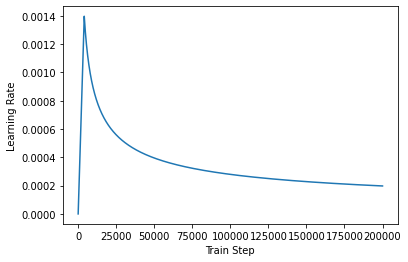

In [70]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [72]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(
    optimizer=optimizer, 
    loss=loss_function, 
    metrics=[accuracy],
)

history = model.fit(dataset, epochs=40, verbose=1)

Epoch 1/20
167/167 [==============================] - 24s 73ms/step - loss: 4.4547 - accuracy: 0.1103
Epoch 2/20
167/167 [==============================] - 12s 73ms/step - loss: 3.5061 - accuracy: 0.1761
Epoch 3/20
167/167 [==============================] - 12s 74ms/step - loss: 3.1774 - accuracy: 0.1832
Epoch 4/20
167/167 [==============================] - 12s 74ms/step - loss: 2.9978 - accuracy: 0.1936
Epoch 5/20
167/167 [==============================] - 12s 74ms/step - loss: 2.8159 - accuracy: 0.2039
Epoch 6/20
167/167 [==============================] - 12s 72ms/step - loss: 2.6112 - accuracy: 0.2181
Epoch 7/20
167/167 [==============================] - 12s 73ms/step - loss: 2.3866 - accuracy: 0.2389
Epoch 8/20
167/167 [==============================] - 12s 73ms/step - loss: 2.1372 - accuracy: 0.2666
Epoch 9/20
167/167 [==============================] - 12s 73ms/step - loss: 1.8743 - accuracy: 0.2962
Epoch 10/20
167/167 [==============================] - 12s 73ms/step - loss: 1.609

In [99]:
# state = ''

def decoder_inference(sentence):
#     global state
    
    sentence = preprocess(sentence)
    # state remember
#     state += ' ' + sentence
#     print(state)
#     sentence = tf.expand_dims(
#         START_TOKEN + tokenizer.encode(state) + END_TOKEN, axis=0
#     )
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)




def sentence_generation(sentence):    
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print(f"🧑 : {sentence}")
    print(f"🤖 : {predicted_sentence}")

In [100]:
sentence_generation('졸려')

🧑 : 졸려
🤖 : 낮잠을 잠깐 자도 괜찮아요 .


In [101]:
sentence_generation('낮잠 자기에는 너무 바쁜데?')

🧑 : 낮잠 자기에는 너무 바쁜데?
🤖 : 귀엽게 봐주세요 .


In [103]:
sentence_generation('싫어')

🧑 : 싫어
🤖 : 싫어하지 말아요 .


In [120]:
sentence_generation('너는 뭘 좋아해?')

🧑 : 너는 뭘 좋아해?
🤖 : 하나라도 있을 거니 열심히 찾아보세요 .


In [125]:
sentence_generation('엄마')

🧑 : 엄마
🤖 : 연락 드려 보세요 .


In [126]:
sentence_generation('아빠')

🧑 : 아빠
🤖 : 여유가 생기예요 .


In [129]:
sentence_generation('조카')

🧑 : 조카
🤖 : 방문 열어주지 마세요 .


In [135]:
범죄와의전쟁 = [
    "씨발롬이! 처돌았나?!",
    "어데서 함부로 손을 놀리노! 느그 서장 어딨어?! 강 서장 대꼬와!!! ",
    "니.. 내 누군지 아나? 으이?! ",
    "내가 이 섀꺄 느그 서장이랑 임마!! ",
    "느그 서장, 남천동 살제? 으어?! ",
    "내가 인마 느그 서장이랑 인마! 어저께도! 같이 밥 묵고 으! ",
    "싸우나도 같이 가고 으! 마 개이 새꺄 마 다했어! ",
]
for s in 범죄와의전쟁:
    sentence_generation(s)
    print("")

🧑 : 씨발롬이! 처돌았나?!
🤖 : 그게 최선이었을 거예요 .

🧑 : 어데서 함부로 손을 놀리노! 느그 서장 어딨어?! 강 서장 대꼬와!!! 
🤖 : 이별에 완전을 느끼나봐요 .

🧑 : 니.. 내 누군지 아나? 으이?! 
🤖 : 찾아빌어요 .

🧑 : 내가 이 섀꺄 느그 서장이랑 임마!! 
🤖 : 여행은 언제나 좋죠 .

🧑 : 느그 서장, 남천동 살제? 으어?! 
🤖 : 고칠 점은 하지 않게 연락해보세요 .

🧑 : 내가 인마 느그 서장이랑 인마! 어저께도! 같이 밥 묵고 으! 
🤖 : 원하던 만큼 땅을 찾아보세요 .

🧑 : 싸우나도 같이 가고 으! 마 개이 새꺄 마 다했어! 
🤖 : 신경쓰이나봐요 .



# 회고

#### Q. Validation set을 왜 나누지 않았을까? 또한 Early stopping도 없다. 

A. 아마 데이터가 부족해서 나누지 않아서 그런 것 같다.


#### 학습된 label이 `질문 -> 응답` 형태가 아니다 보니, 응답이 부자연스럽다. 

다만 ~하죠, ~세요와 같이 'A'에 자주 있는 어투로 대답을 잘하고 있다.


#### 범죄와의 전쟁 최민식과 같이 무례한 말투에도, 따뜻하게 대답한다.

#### df['A']의 말투를 따라서 비슷한 말투를 가진다.


- [x] 배운 점 | 3가지 attention과 encoder-decoder의 세부 구조
- [x] 아쉬운 점 | 해당 트랜스포머 모델을 잘 평가하는 척도를 더 알아보고 싶다.
- [x] 느낀 점 | llm의 경우 특히 데이터가 중요하다. 데이터를 통해서 결국 어투도 완성되는 느낌이 크다.
- [x] 어려웠던 점 | shape들을 매칭하는 것이 주석을 달지 않으면 좀 헷갈릴 때가 있다.